Training image classification models with ANNs

- Dataset: 
    - https://www.kaggle.com/pybear/cats-vs-dogs?select=PetImages


In [1]:
import os
import pathlib
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image, ImageOps
from IPython.display import display
from sklearn.utils import shuffle
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
warnings.filterwarnings('ignore')

- Let's load in an arbitrary image:

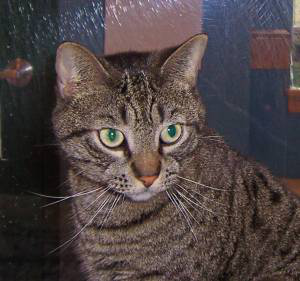

In [2]:
src_img = Image.open(r'C:\Users\oabdo\Desktop\PetImages\Cat\1.jpg')
display(src_img)

- Here's the shape (width, height, color channels):

In [3]:
np.array(src_img).shape

(281, 300, 3)

- If flattened, it would result in this many features:

In [4]:
281 * 300 * 3

252900

- We can reduce the number by a factor of 3 by grayscaling the image
- We still know it's a cat, no matter if we lose the color info:

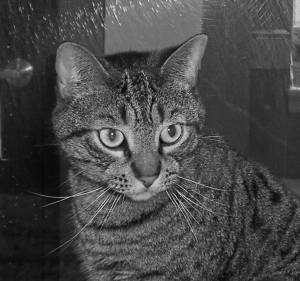

In [5]:
gray_img = ImageOps.grayscale(src_img)
display(gray_img)

In [6]:
np.array(gray_img).shape

(281, 300)

In [7]:
281 * 300

84300

- It's still a lot, so let's resize the image to something smaller
- Let's say 96x96:

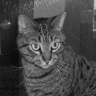

In [8]:
gray_resized_img = gray_img.resize(size=(96, 96))
display(gray_resized_img)

In [9]:
np.array(gray_resized_img).shape

(96, 96)

- Much less features:

In [10]:
96 * 96

9216

- This is how you can flatten the image and store it as an array:

In [11]:
np.ravel(gray_resized_img)

array([42, 42, 51, ..., 68, 37, 36], dtype=uint8)

- The values aren't in an ideal range (0-255)
- Neural network model prefers 0-1 range
- Let's transform it:

In [12]:
img_final = np.ravel(gray_resized_img) / 255.0

In [13]:
img_final

array([0.16470588, 0.16470588, 0.2       , ..., 0.26666667, 0.14509804,
       0.14117647])

- Finally, let's implement all of this in a single function:

In [14]:
def process_image(img_path: str) -> np.array:
    img = Image.open(img_path)
    img = ImageOps.grayscale(img)
    img = img.resize(size=(96, 96))
    img = np.ravel(img) / 255.0
    return img

- And let's test it:

In [15]:
tst_img = process_image(r'C:\Users\oabdo\Desktop\PetImages\Dog\112.jpg')


In [16]:
tst_img

array([0.45098039, 0.46666667, 0.45490196, ..., 0.59607843, 0.55294118,
       0.34117647])

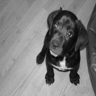

In [17]:
Image.fromarray(np.uint8(tst_img * 255).reshape((96, 96)))

- It works as expected, so let's apply the same logic to the entire dataset next.

<br>

## Process the entire dataset

- Let's declare a function that will process all images in a given folder
- The function returns processed images as a Pandas DataFrame
- We'll add an additional column just so we know the class:

In [18]:
def process_folder(folder: pathlib.PosixPath) -> pd.DataFrame:
    # We'll store the images here
    processed = []
    
    # For every image in the directory
    for img in folder.iterdir():
        # Ensure JPG
        if img.suffix == '.jpg':
            # Two images failed for whatever reason, so let's just ignore them
            try:
                processed.append(process_image(img_path=str(img)))
            except Exception as _:
                continue
           
    # Convert to pd.DataFrame
    processed = pd.DataFrame(processed)
    # Add a class column - dog or a cat
    processed['class'] = folder.parts[-1]
    
    return processed

- And now let's build ourselves training, validation, and test sets
- We'll start with the training set
    - Process both cat and dog images
    - Concatenate the two datasets
    - Save them in a pickle format, just so you don't have to go through the entire process again

In [19]:
%%time

train_cat = process_folder(folder=pathlib.Path.cwd().joinpath(r'C:\Users\oabdo\Desktop\PetImages\Cat'))
train_dog = process_folder(folder=pathlib.Path.cwd().joinpath(r'C:\Users\oabdo\Desktop\PetImages\Dog'))

train_set = pd.concat([train_cat, train_dog], axis=0)

with open('train_set.pkl', 'wb') as f:
    pickle.dump(train_set, f)

Wall time: 2min 29s


In [20]:
train_set.head()

,0,1,2,3,4,5,6,7,8,9,...,9207,9208,9209,9210,9211,9212,9213,9214,9215,class
0,0.662745,0.678431,0.698039,0.713725,0.725490,0.737255,0.749020,0.760784,0.772549,0.780392,...,0.007843,0.011765,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,Cat
1,0.164706,0.164706,0.200000,0.168627,0.180392,0.160784,0.168627,0.156863,0.172549,0.184314,...,0.188235,0.207843,0.219608,0.215686,0.250980,0.286275,0.266667,0.145098,0.141176,Cat
2,0.133333,0.125490,0.172549,0.176471,0.180392,0.211765,0.223529,0.219608,0.215686,0.215686,...,0.631373,0.596078,0.513725,0.509804,0.556863,0.611765,0.658824,0.670588,0.603922,Cat
3,0.870588,0.874510,0.870588,0.886275,0.894118,0.882353,0.894118,0.909804,0.898039,0.894118,...,0.854902,0.796078,0.800000,0.803922,0.835294,0.866667,0.850980,0.831373,0.835294,Cat
4,0.435294,0.458824,0.494118,0.345098,0.274510,0.415686,0.533333,0.545098,0.713725,0.580392,...,0.364706,0.384314,0.368627,0.368627,0.450980,0.396078,0.349020,0.364706,0.325490,Cat


In [21]:
train_set.shape

(24998, 9217)

- Now for the test set:

In [23]:
%%time

test_cat = process_folder(folder=pathlib.Path.cwd().joinpath(r'C:\Users\oabdo\Desktop\PetImages\Cat'))
test_dog = process_folder(folder=pathlib.Path.cwd().joinpath(r'C:\Users\oabdo\Desktop\PetImages\Dog'))

test_set = pd.concat([test_cat, test_dog], axis=0)

with open('test_set.pkl', 'wb') as f:
    pickle.dump(test_set, f)

Wall time: 2min 30s


In [24]:
test_set.shape

(24998, 9217)

- And finally for the validation set:

In [26]:
%%time

valid_cat = process_folder(folder=pathlib.Path.cwd().joinpath(r'C:\Users\oabdo\Desktop\PetImages\Cat'))
valid_dog = process_folder(folder=pathlib.Path.cwd().joinpath(r'C:\Users\oabdo\Desktop\PetImages\Dog'))

valid_set = pd.concat([valid_cat, valid_dog], axis=0)

with open('valid_set.pkl', 'wb') as f:
    pickle.dump(valid_set, f)

Wall time: 2min 31s


In [27]:
valid_set.shape

(24998, 9217)

<br>

## Additional processing
- Datasets now contain images of cats first, followed by images of dogs
- We want to shuffle those datasets, so a neural network  goes through the images in a random order:

In [28]:
train_set = shuffle(train_set).reset_index(drop=True)
valid_set = shuffle(valid_set).reset_index(drop=True)

In [29]:
train_set.head()

,0,1,2,3,4,5,6,7,8,9,...,9207,9208,9209,9210,9211,9212,9213,9214,9215,class
0,0.392157,0.396078,0.403922,0.400000,0.403922,0.407843,0.411765,0.411765,0.415686,0.419608,...,0.176471,0.176471,0.188235,0.168627,0.172549,0.172549,0.156863,0.168627,0.152941,Cat
1,0.803922,0.811765,0.807843,0.803922,0.800000,0.811765,0.788235,0.764706,0.776471,0.800000,...,0.431373,0.462745,0.341176,0.380392,0.403922,0.423529,0.368627,0.384314,0.443137,Dog
2,0.125490,0.109804,0.149020,0.141176,0.145098,0.160784,0.141176,0.047059,0.019608,0.023529,...,0.196078,0.184314,0.235294,0.156863,0.188235,0.250980,0.192157,0.262745,0.294118,Dog
3,0.482353,0.513725,0.564706,0.525490,0.443137,0.447059,0.462745,0.443137,0.435294,0.427451,...,0.643137,0.592157,0.588235,0.584314,0.556863,0.588235,0.611765,0.513725,0.466667,Dog
4,0.494118,0.443137,0.415686,0.403922,0.529412,0.541176,0.541176,0.647059,0.666667,0.505882,...,0.772549,0.768627,0.745098,0.756863,0.756863,0.725490,0.721569,0.713725,0.694118,Cat


- Separate the features from the target:

In [30]:
X_train = train_set.drop('class', axis=1)
y_train = train_set['class']

X_valid = valid_set.drop('class', axis=1)
y_valid = valid_set['class']

X_test = test_set.drop('class', axis=1)
y_test = test_set['class']

- We need to factorize the target variable
- For example, if our classes are ['cat', 'dog'], the function will convert them to integers [0, 1]
- Then, each instance is represented as follows:
    - Cat: [1, 0]
    - Dog: [0, 1]

In [31]:
y_train.factorize()

(array([0, 1, 1, ..., 1, 0, 1], dtype=int64),
 Index(['Cat', 'Dog'], dtype='object'))

In [32]:
y_train = tf.keras.utils.to_categorical(y_train.factorize()[0], num_classes=2)
y_valid = tf.keras.utils.to_categorical(y_valid.factorize()[0], num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test.factorize()[0], num_classes=2)

In [33]:
y_train[:5]

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

<br>

## Training the model
- The architecture and parameters are completely random
- Set it to whatever you want
- We have two nodes at the output layer
    - Represents two classes - cat and dog
- We're using Categorical Crossentropy as a loss function because we have two categories - cat and dog
- The model is trained for 100 epochs with a batch size of 128:

In [34]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=128,
    validation_data=(X_valid, y_valid)
)

Epoch 1/100
196/196 [==============================] - 42s 200ms/step - loss: 0.9118 - accuracy: 0.5480 - val_loss: 0.8021 - val_accuracy: 0.4493
Epoch 2/100
196/196 [==============================] - 22s 112ms/step - loss: 0.6697 - accuracy: 0.5896 - val_loss: 0.7501 - val_accuracy: 0.4058
Epoch 3/100
196/196 [==============================] - 22s 112ms/step - loss: 0.6620 - accuracy: 0.5990 - val_loss: 0.7853 - val_accuracy: 0.3880
Epoch 4/100
196/196 [==============================] - 22s 113ms/step - loss: 0.6569 - accuracy: 0.6078 - val_loss: 0.8341 - val_accuracy: 0.3842
Epoch 5/100
196/196 [==============================] - 22s 110ms/step - loss: 0.6541 - accuracy: 0.6175 - val_loss: 0.8597 - val_accuracy: 0.3820
Epoch 6/100
196/196 [==============================] - 23s 119ms/step - loss: 0.6479 - accuracy: 0.6216 - val_loss: 0.9550 - val_accuracy: 0.3998
Epoch 7/100
196/196 [==============================] - 23s 119ms/step - loss: 0.6494 - accuracy: 0.6157 - val_loss: 0.8878 -

<br>

## Inspecting performance
- It doesn't look like the best model, as ANNs aren't the best tool for image data
- Let's visualize training loss vs. validation loss and training accuracy vs. validation accuracy

In [35]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (18, 8)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

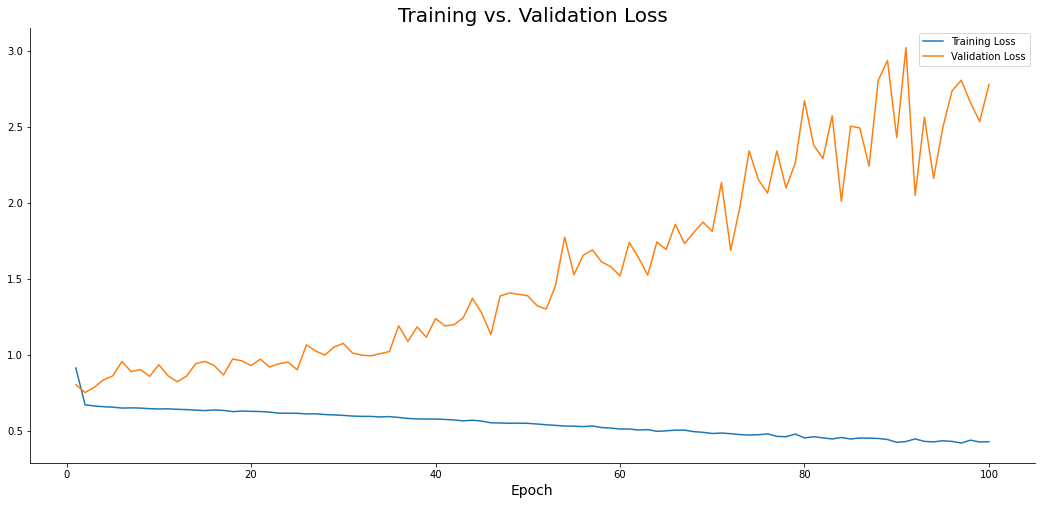

In [36]:
plt.plot(np.arange(1, 101), history.history['loss'], label='Training Loss')
plt.plot(np.arange(1, 101), history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();

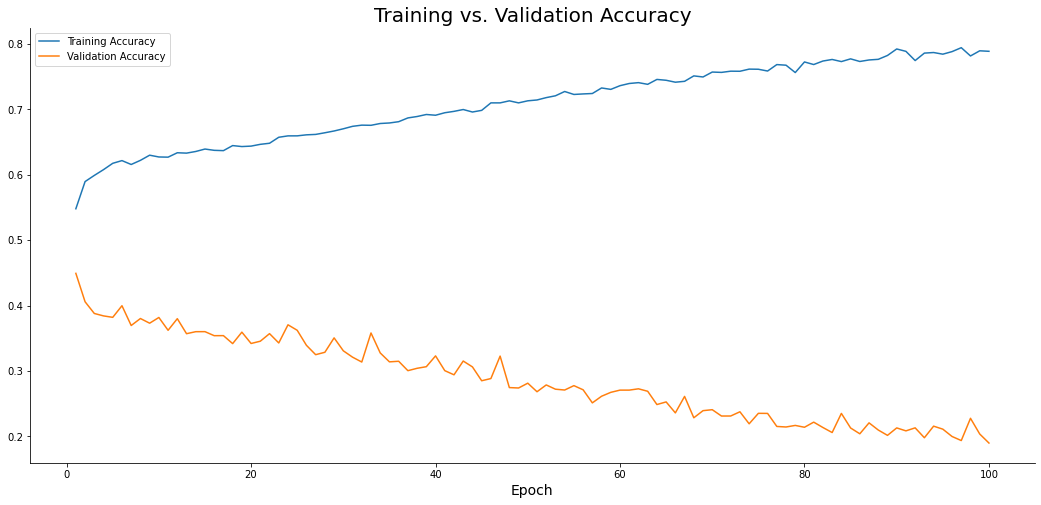

In [37]:
plt.plot(np.arange(1, 101), history.history['accuracy'], label='Training Accuracy')
plt.plot(np.arange(1, 101), history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();

- The performance is terrible
- Convolutions can help, and you'll see how in the following notebook

In [68]:
from sklearn.metrics import accuracy_score
accuracy_score(y_valid , x_train)

0.4986798943915513

In [90]:
print(confusion_matrix(y_test.argmax(axis=1), y_valid.argmax(axis=1)))


[[6278 6221]
 [6221 6278]]


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.903


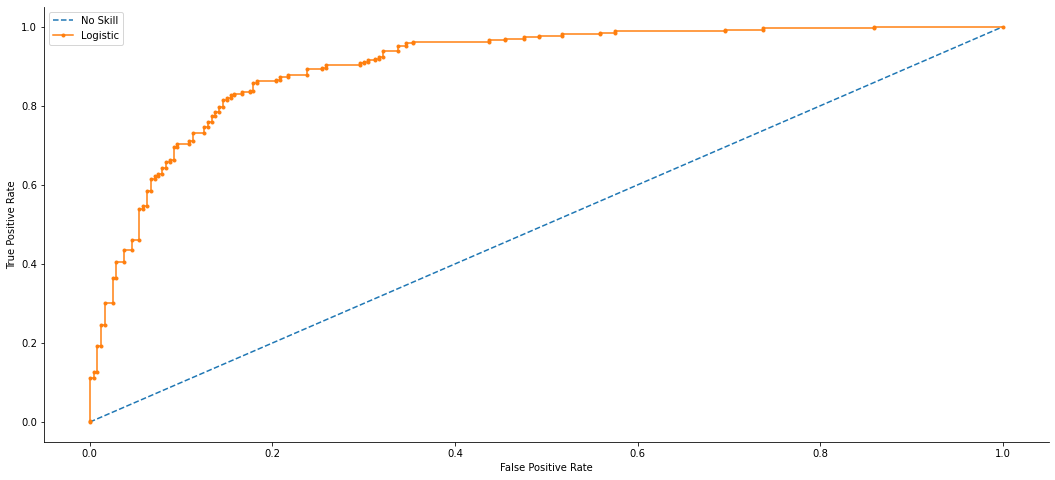

In [84]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()